In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. 데이터 둘러보기

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-9/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-9/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/3-9/sample_submission.csv')

In [5]:
df = df_train.drop(['id'], axis = 1)

In [14]:
df.head(10)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
5,350.0,0.0,0.0,203.0,0.0,1055.0,775.0,7,37.43
6,135.7,203.5,0.0,185.7,0.0,1076.2,759.3,28,35.10
7,332.5,142.5,0.0,228.0,0.0,932.0,594.0,28,45.94
8,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,42.14
9,133.0,200.0,0.0,192.0,0.0,927.4,839.2,3,6.94


<컬럼 설명>
* CementComponent : 시멘트 혼합량  
* BlastFurnaceSlag : 용광로 혼합량
* FlyAshComponent : 비산회 혼합량  
* WaterComponent : 물 혼합량  
* SuperplasticizerComponent : 슈퍼 가소제 혼합량  
* CoarseAggregateComponent : 거친 골재 혼합량
* FineAggregateComponent : 미세 골재 혼합량
* AgeInDays : 건조된 상태로 방치된 일 수
* Strength : 최종 콘크리트 강도(압축강도) (target label)

* 범주형 변수
               X
* 연속형 변수
               'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'Strength'

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5407 entries, 0 to 5406
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            5407 non-null   float64
 1   BlastFurnaceSlag           5407 non-null   float64
 2   FlyAshComponent            5407 non-null   float64
 3   WaterComponent             5407 non-null   float64
 4   SuperplasticizerComponent  5407 non-null   float64
 5   CoarseAggregateComponent   5407 non-null   float64
 6   FineAggregateComponent     5407 non-null   float64
 7   AgeInDays                  5407 non-null   int64  
 8   Strength                   5407 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 380.3 KB


In [16]:
df.describe() # 범주형 데이터도 확인하고 싶다면 include = np.object_ 사용

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [24]:
#데이터 내용 간단히 정리해서 출력하기
print("총 데이터 개수: ", df.shape[0] * df.shape[1])
print("총 결측치 수: {} = 전체 데이터의 {:.2f}% ".format(df.isnull().sum().sum(), (df.isnull().sum().sum()*100)/(df.shape[0]*df.shape[1])))
print("콘크리트 강도 최대 값 : ", df['Strength'].max())
print("콘크리트 강도 최소 값 : ", df['Strength'].min())
print("콘크리트 강도 평균 값 : " ,df['Strength'].mean())

총 데이터 개수:  48663
총 결측치 수: 0 = 전체 데이터의 0.00% 
콘크리트 강도 최대 값 :  82.6
콘크리트 강도 최소 값 :  2.33
콘크리트 강도 평균 값 :  35.45207138894026


#2.데이터를 보고 질문 만들기

* 콘크리트 강도가 높을수록 다른 컬럼들의 분포는?
* 콘크리트를 구성하는 골재 비율은?
* 방치된 일 수가 특출나게 높은 데이터는?

# 3. 데이터 정비하기

## 3.1 파생 변수 생성

In [22]:
# 골재 총합
df['totalAggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent'] 
# 혼합량 총합
df['totalComponent'] = df[df.columns[0]] + df[df.columns[1]] + df[df.columns[2]] + df[df.columns[3]] + df[df.columns[4]] + df[df.columns[9]]
# 골재 비율 = (골재 총합 / 혼합량 총합) * 100
df['aggregate_ratio'] = round((df['totalAggregate'] / df['totalComponent']) * 100, 1)
df.head() 

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,totalAggregate,totalComponent,aggregate_ratio
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1738.0,2449.0,71.0
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1610.0,2264.0,71.1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1870.3,2479.7,75.4
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1602.0,2210.0,72.5
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1716.6,2301.6,74.6


# 4. EDA & Visualization

## 4.1 콘크리트 강도가 높을수록 다른 컬럼들의 분포

In [25]:
# 콘크리트 강도 최대값의 데이터
df[df['Strength'] == df['Strength'].max()]

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
1760,475.0,0.0,0.0,228.0,0.0,932.0,713.2,28,82.6
3623,313.3,0.0,113.0,179.6,8.9,1001.9,688.7,28,82.6


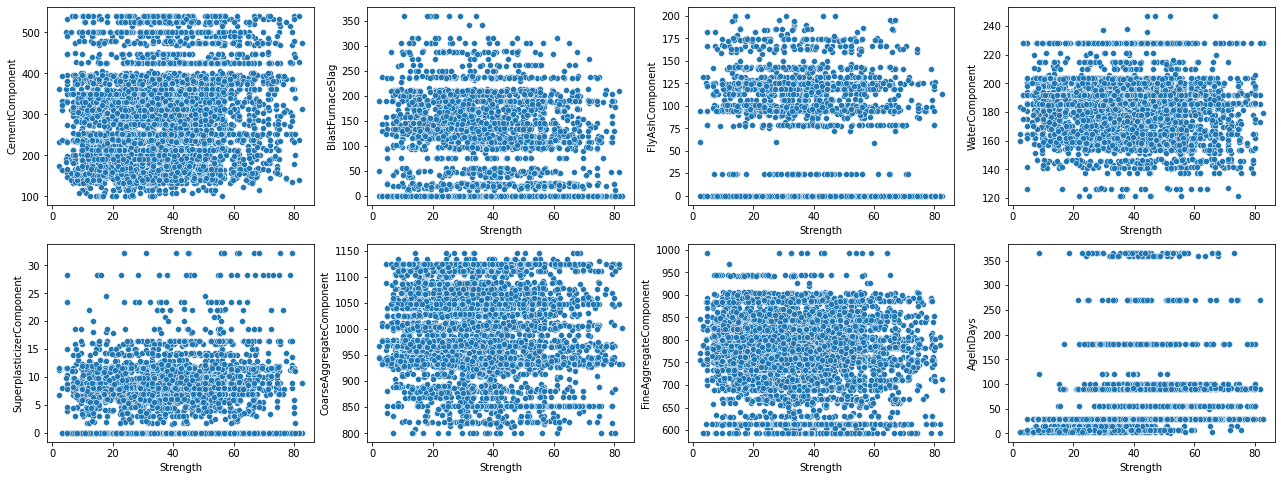

In [6]:
f, ax = plt.subplots(2, 4, figsize = (22, 8))

sns.scatterplot(data = df, x = 'Strength', y = 'CementComponent', ax = ax[0,0])
sns.scatterplot(data = df, x = 'Strength', y = 'BlastFurnaceSlag', ax = ax[0,1])
sns.scatterplot(data = df, x = 'Strength', y = 'FlyAshComponent', ax = ax[0,2])
sns.scatterplot(data = df, x = 'Strength', y = 'WaterComponent', ax = ax[0,3])
sns.scatterplot(data = df, x = 'Strength', y = 'SuperplasticizerComponent', ax = ax[1,0])
sns.scatterplot(data = df, x = 'Strength', y = 'CoarseAggregateComponent', ax = ax[1,1])
sns.scatterplot(data = df, x = 'Strength', y = 'FineAggregateComponent', ax = ax[1,2])
sns.scatterplot(data = df, x = 'Strength', y = 'AgeInDays', ax = ax[1,3])

plt.show()

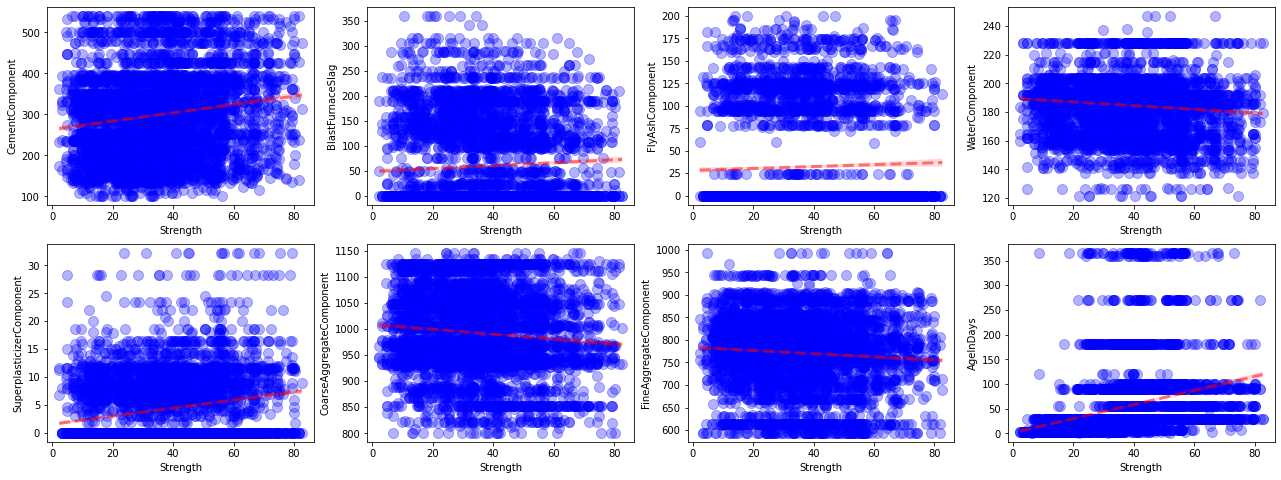

In [14]:
f, ax = plt.subplots(2, 4, figsize = (22, 8))

sns.regplot(data = df, x = 'Strength', y = 'CementComponent', ax = ax[0,0], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'BlastFurnaceSlag', ax = ax[0,1], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'FlyAshComponent', ax = ax[0,2], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'WaterComponent', ax = ax[0,3], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'SuperplasticizerComponent', ax = ax[1,0], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'CoarseAggregateComponent', ax = ax[1,1], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'FineAggregateComponent', ax = ax[1,2], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
sns.regplot(data = df, x = 'Strength', y = 'AgeInDays', ax = ax[1,3], scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})

plt.show()

## 4.2 콘크리트를 구성하는 골재 비율

In [24]:
df['aggregate_ratio'].describe()

count    5407.000000
mean       75.323007
std         3.862957
min        62.800000
25%        72.300000
50%        76.000000
75%        77.900000
max        86.100000
Name: aggregate_ratio, dtype: float64

<AxesSubplot:xlabel='Strength', ylabel='aggregate_ratio'>

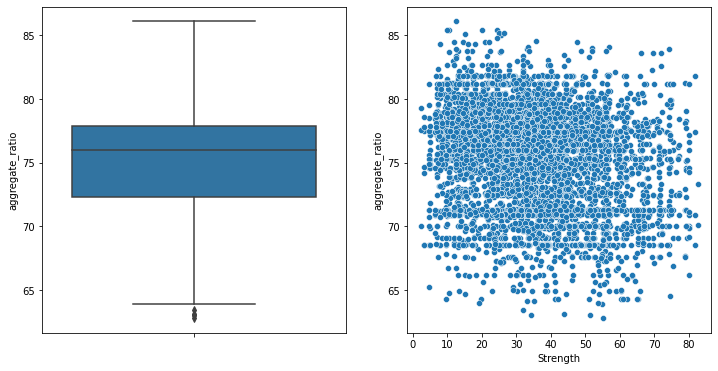

In [27]:
f , ax = plt.subplots(1, 2, figsize = (12, 6))

sns.boxplot(data = df, y = 'aggregate_ratio', ax = ax[0])
sns.scatterplot(data = df, x = 'Strength', y = 'aggregate_ratio')

<AxesSubplot:xlabel='Strength'>

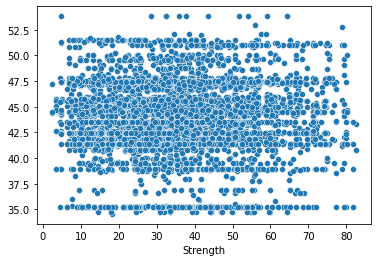

In [28]:
# 총 골재량에서 미세 골재량의 비율을 알아보자

sns.scatterplot(data = df, x = 'Strength', y = (df['FineAggregateComponent'] / df['totalAggregate'] * 100)) 

## 4.3 특출나게 오래 방치된 데이터

<AxesSubplot:ylabel='AgeInDays'>

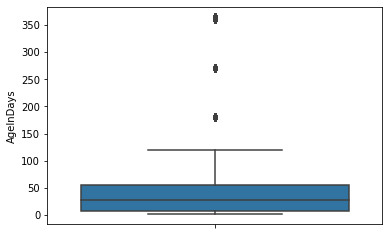

In [30]:
sns.boxplot(data = df, y = 'AgeInDays')

In [36]:
df['AgeInDays'].value_counts()

28     2097
7       796
3       639
90      540
56      313
180     264
14      249
100     212
365      91
270      75
91       73
360      37
120      15
1         5
49        1
Name: AgeInDays, dtype: int64

In [35]:
df[df['AgeInDays'] >= 180]

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,totalAggregate,totalComponent,aggregate_ratio
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1602.0,2210.0,72.5
8,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,42.14,1774.0,2299.0,77.2
10,500.0,0.0,0.0,200.0,0.0,1125.0,613.0,270,65.20,1738.0,2438.0,71.3
56,236.0,0.0,0.0,194.0,0.0,968.0,885.0,180,25.18,1853.0,2283.0,81.2
59,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,32.11,1774.0,2299.0,77.2
...,...,...,...,...,...,...,...,...,...,...,...,...
5325,349.0,0.0,0.0,192.0,0.0,1047.0,806.0,180,41.93,1853.0,2394.0,77.4
5354,331.0,0.0,0.0,192.0,0.0,1025.0,765.0,360,46.25,1790.0,2313.0,77.4
5367,190.0,190.0,0.0,228.0,0.0,932.0,670.0,180,71.62,1602.0,2210.0,72.5
5390,500.0,153.0,0.0,200.0,0.0,1125.0,613.0,180,69.84,1738.0,2591.0,67.1


# 5. Review

* 콘크리트 강도 데이터는:  
총 데이터 개수:  48663  
총 결측치 수: 0 = 전체 데이터의 0.00%   
콘크리트 강도 최대 값 :  82.6  
콘크리트 강도 최소 값 :  2.33  
콘크리트 강도 평균 값 :  35.452

* 콘크리트 강도가 높을수록 다른 컬럼들의 분포는?  
  : 콘크리트 강도와 비례/반비례 관계를 지는 컬럼은 없는 것 같다. 대체로 골고루 분포되어 있는 것으로 보인다.  
  : 방치된 일 수가 다른 컬럼들에 비해 비례 관계를 가지는 것을 알 수 있다.  

* 콘크리트를 구성하는 골재 비율은?  
  : 골재는 65 ~ 85% 차지하고 있다.  
  : 총합 골재 비율, 미세 골재 비율로는 강도에 영향이 있는지는 알 수 없다. 

#6. Modeling

## 6.1 Baseline model

In [ ]:
X_train = df_train.drop(['id', 'Strength'], axis = 1)
y_train = df_train['Strength']

X_test = df_test.drop(['id'], axis = 1)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

model = xgb.XGBRegressor()
model.fit(X_tr, y_tr)
score = mean_squared_error(y_vld, model.predict(X_vld))
score

160.1728551010044

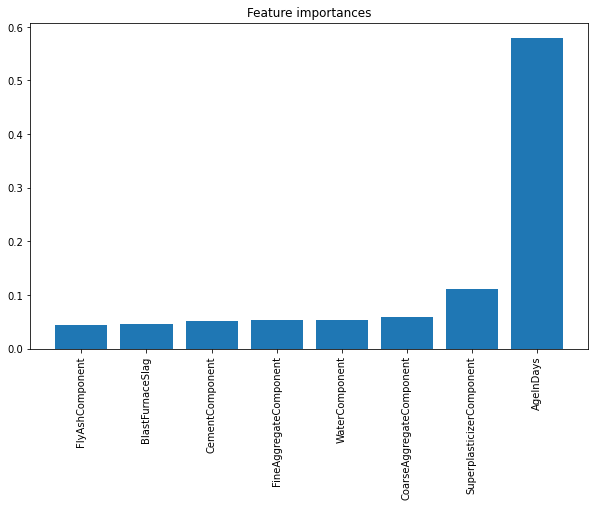

In [ ]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [ ]:
predictions = model.predict(X_test)
predictions

array([44.749374, 18.792154, 33.12571 , ..., 49.477467, 42.276142,
       22.628086], dtype=float32)

In [ ]:
sub['Strength'] = predictions
sub.to_csv('/content/drive/MyDrive/data/3-9/sample_submission.csv', index = False)